In [1]:
import logging
logging.basicConfig(level=logging.INFO)
from utils_segmentation import *

plots = True

cmap = mpl.colors.ListedColormap(['y', 'r', 'g','w','b','m','c','k'])
norm = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6,7,8], cmap.N)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [165]:
cook_hy2023_v1 = pd.read_csv('F:/usda/work/CookIRCamET/Working/cookhy2023_V1_output.csv')
cook_hy2023_v2 = pd.read_csv('F:/usda/work/CookIRCamET/Working/cookhy2023_V2_output.csv')
cprl_hy2023_v1 = pd.read_csv('F:/usda/work/CookIRCamET/Working/cprlhy2023_V1_output.csv')
cprl_hy2023_v2 = pd.read_csv('F:/usda/work/CookIRCamET/Working/cprlhy2023_V2_output.csv')
cprl_hy2023_irt = pd.read_csv('F:/usda/raw/CookIRCamET/Meteorological/Cprl/ne_lys_simple.csv')

In [166]:
cprl_hy2023_v1['times']=pd.to_datetime(cprl_hy2023_v1['times'])
cprl_hy2023_v2['times']=pd.to_datetime(cprl_hy2023_v2['times'])
cook_hy2023_v1['times']=pd.to_datetime(cook_hy2023_v1['times'])
cook_hy2023_v2['times']=pd.to_datetime(cook_hy2023_v2['times'])

In [167]:
cprl_hy2023_irt['times'] = cprl_hy2023_irt.apply(lambda p: pytz.utc.localize(datetime.strptime(p.Date+' '+str((p.Hour+5)%24)+':'+str(p.Minute),'%m/%d/%Y %H:%M')),axis=1)

In [168]:
cprl_hy2023_irt['Dry Soil IRT']=cprl_hy2023_irt['Dry Soil IRT']+273.15

In [175]:
xlim=[pd.to_datetime('2023-7-19 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-7-24 00:00:00',format='%Y-%m-%d %H:%M:%S')]

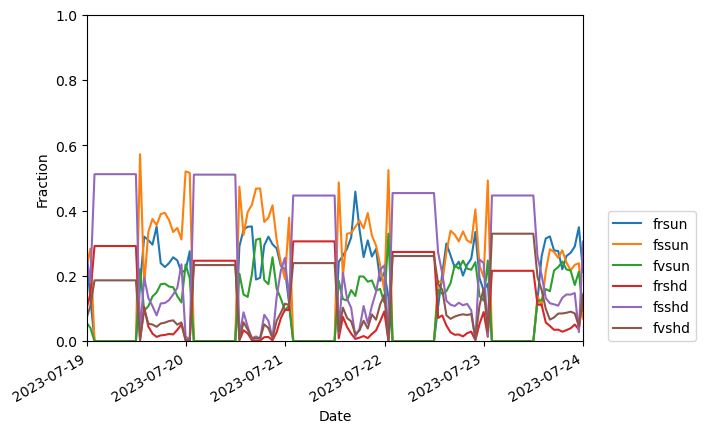

In [176]:
fig=cprl_hy2023_v2.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=xlim,ylim=[0,1])
ax = fig.axes
ax.set_xlabel('Date')
ax.set_ylabel('Fraction')
ax.legend(loc=[1.05 ,0])
fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v2_f.png'),dpi=300,bbox_inches='tight')

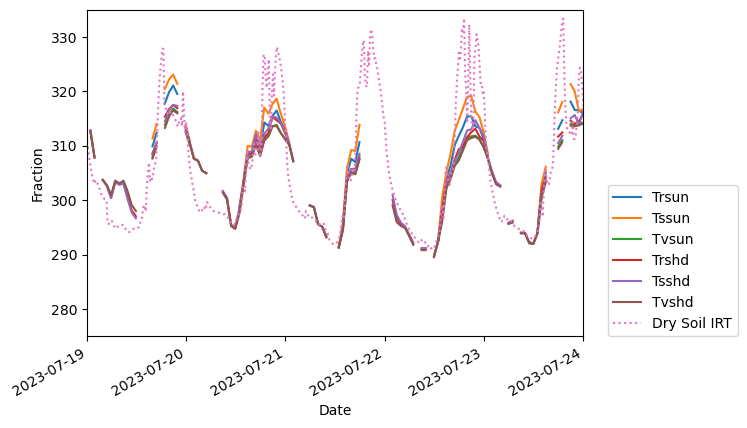

In [177]:
fig = cprl_hy2023_v2.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[275,340])
ax = fig.axes
#fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v2_t.png'),dpi=300)
cprl_hy2023_irt.plot(ax=ax,x='times',y=['Dry Soil IRT'],xlim=xlim,ylim=[275,335],linestyle=':')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction')
ax.legend(loc=[1.05 ,0])
fig.get_figure().savefig(os.path.join(p3,'cprl_hy2023_v2_irt.png'),dpi=300,bbox_inches='tight')
plt.show()

In [178]:
cprl_hy2023_irt.times

0     2023-07-15 05:00:00+00:00
1     2023-07-15 05:15:00+00:00
2     2023-07-15 05:30:00+00:00
3     2023-07-15 05:45:00+00:00
4     2023-07-15 06:00:00+00:00
                 ...           
955   2023-07-24 03:45:00+00:00
956   2023-07-24 04:00:00+00:00
957   2023-07-24 04:15:00+00:00
958   2023-07-24 04:30:00+00:00
959   2023-07-24 04:45:00+00:00
Name: times, Length: 960, dtype: datetime64[ns, UTC]

In [179]:
xlim=[pd.to_datetime('2023-06-25 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]

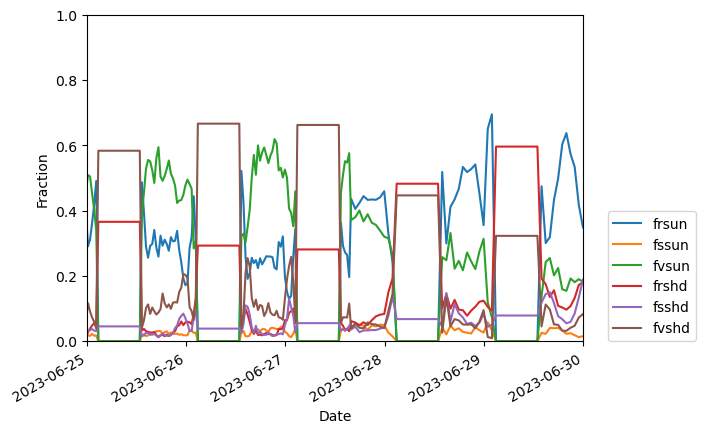

In [180]:
fig=cook_hy2023_v2.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=xlim,ylim=[0,1])
ax = fig.axes
ax.set_xlabel('Date')
ax.set_ylabel('Fraction')
ax.legend(loc=[1.05 ,0])
fig.get_figure().savefig(os.path.join(p3,'cook_hy2023_v2_f.png'),dpi=300,bbox_inches='tight')

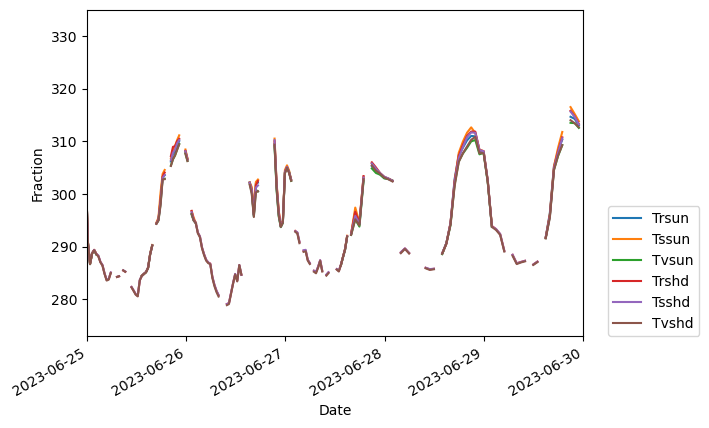

In [181]:
fig=cook_hy2023_v2.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[273,335])
ax = fig.axes
ax.set_xlabel('Date')
ax.set_ylabel('Fraction')
ax.legend(loc=[1.05 ,0])
fig.get_figure().savefig(os.path.join(p3,'cook_hy2023_v2_t.png'),dpi=300,bbox_inches='tight')